### SQL-Abfragen in Relationale Algebra konvertieren

Projection
    Selection
        CrossProduct
            ThetaJoin
                Selection
                    Relation
                Relation
            SubqueryScan
                Projection
                    Map
                        GroupBy
                            Selection
                                CrossProduct
                                    Relation
                                    ThetaJoin
                                        Selection
                                            Relation
                                        Relation
π (s.name, e.course)
  <- σ (e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- <<Scalar Subquery Scan>>
        <- π (MIN(e2.grade))
          <- γ (e2.grade: MIN(e2.grade))
            <- ⋈ ϴ=(s.id = e2.sid)
              <- ⋈ ϴ=(s.id = e.sid)
                <- s
                <- e
              <- e2
π (s.name, e.cours

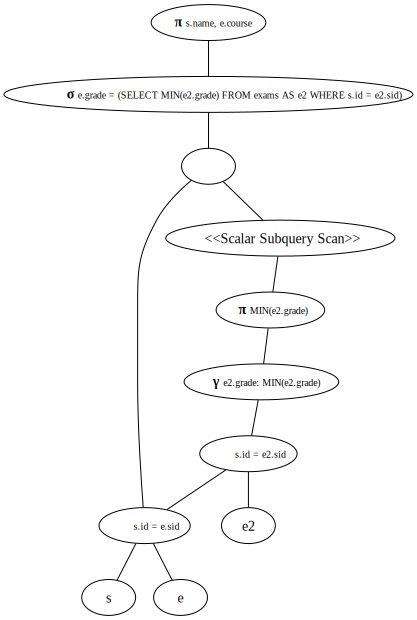

In [1]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.note>=(select avg(e2.note)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)

print(parser.str_relalg(relalg_query_2))
print(relalg_query_1.inspect())
print(relalg_query_2.inspect())

opt_vis.plot_relalg(relalg_query_1)

### Optimierung

⋈ ϴ=(s.id = e.sid)
  <- s
  <- e
π (MIN(e2.grade))
  <- γ (e2.grade: MIN(e2.grade))
    <- ⋈ ϴ=(s.id = e2.sid)
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- e2
▶◁
  <- ⋈ ϴ=(s.id = e.sid)
    <- s
    <- e
  <- π (MIN(e2.grade))
    <- γ (e2.grade: MIN(e2.grade))
      <- ⋈ ϴ=(s.id = e2.sid)
        <- DummyTable
        <- e2
π (s.name, e.course)
  <- σ (e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid))
    <- ⋈ ϴ=(d.id = s.id)
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- ▶◁
        <- π (d.id)
          <- ϱ (s.id: d.id)
            <- ⋈ ϴ=(s.id = e.sid)
              <- s
              <- e
        <- π (MIN(e2.grade))
          <- γ (e2.grade: MIN(e2.grade))
            <- ⋈ ϴ=(d.id = e2.sid)
              <- DummyTable
              <- e2


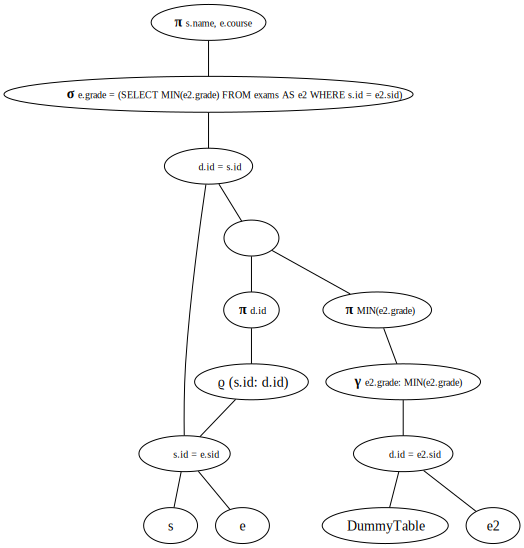

In [2]:
from src.optimizer.push_down_manager import PushDownManager
from src.utils.utils import Utils
from src.optimizer.optimizer import Optimizer

utils = Utils()
pushDownManager = PushDownManager(utils)
optimizer = Optimizer(pushDownManager, utils)
t1, t2, dependent_join, d = optimizer.optimize_unnesting(relalg_query_1)

print(t1.inspect())
print(t2.inspect())
print(dependent_join.inspect())
print(d.inspect())

opt_vis.plot_relalg(d)


In [3]:
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
print(query_generator.generate_sql_from_relalg(d))



WITH outerquery AS (SELECT e.grade, e.course, s.id, s.name FROM students s, exams e WHERE s.id = e.sid),
dup_elim_outerquery AS (SELECT DISTINCT id FROM outerquery)
SELECT oq.name, oq.course FROM outerquery oq  JOIN () as subquery ON oq.id = subquery.id WHERE oq.grade = m1


⋈ ϴ=(s.id = e.sid)
⋈ ϴ=(d.id = s.id)
frozenset({Rename(ThetaJoin(s, e))})
Projection
  <- Selection
    Parent: Projection
    Predicate: e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid)
    <- ThetaJoin
      Parent: Selection
      Predicate: d.id = s.id
      <- ThetaJoin
        Parent: ThetaJoin
        Predicate: s.id = e.sid
        Sideways Pass: ['Rename']
        <- Relation
          Parent: ThetaJoin
        <- Relation
          Parent: ThetaJoin
      <- Projection
        Parent: ThetaJoin
        <- DependentJoin
          Parent: Projection
          <- Projection
            Parent: DependentJoin
            <- Rename
              Parent: Projection
              <- ThetaJoin
                Parent: Rename
                Predicate: s.id = e.sid
                <- Relation
                  Parent: ThetaJoin
                <- Relation
                  Parent: ThetaJoin
          <- GroupBy
            Parent: DependentJoin
            <- ThetaJ

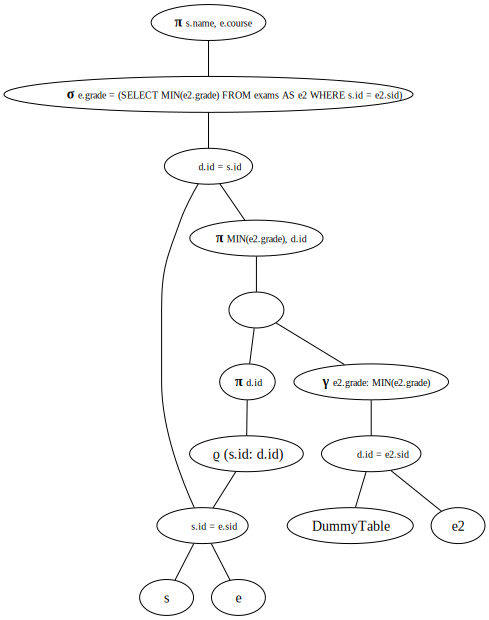

In [4]:
push_down = pushDownManager.push_down(d)
print(utils.detailed_structure_visualization(push_down))
opt_vis.plot_relalg(push_down)

In [5]:
print(Utils.detailed_structure_visualization(dependent_join))
from postbound.qal import base, predicates, expressions, relalg

tab_r = base.TableReference("R")
tab_s = base.TableReference("S")
col_r_a = base.ColumnReference("a", tab_r)
col_s_a = base.ColumnReference("a", tab_s)
col_r_b = base.ColumnReference("b", tab_r)
col_s_b = base.ColumnReference("b", tab_s)

join_pred_1 = predicates.as_predicate(col_r_a, expressions.LogicalSqlOperators.Equal, col_s_a)
join_pred_2 = predicates.as_predicate(col_r_b, expressions.LogicalSqlOperators.Equal, col_s_b)

# Our old relalg tree: Projection(Select(CrossProduct(R, S)))
scan_r = relalg.Relation(tab_r, [col_r_a])
scan_s = relalg.Relation(tab_s, [col_s_a])
root = relalg.ThetaJoin(scan_r, scan_s, predicates.CompoundPredicate.create_and([join_pred_1, join_pred_2]))

print(root.inspect())


DependentJoin
  <- ThetaJoin
    Parent: DependentJoin
    Predicate: s.id = e.sid
    <- Relation
      Parent: ThetaJoin
    <- Relation
      Parent: ThetaJoin
  <- Projection
    Parent: DependentJoin
    <- GroupBy
      Parent: Projection
      <- ThetaJoin
        Parent: GroupBy
        Predicate: s.id = e2.sid
        <- Relation
          Parent: ThetaJoin
        <- Relation
          Parent: ThetaJoin
⋈ ϴ=(R.a = S.a AND R.b = S.b)
  <- R
  <- S
